In [1]:
import sys
import numpy as np
import pickle
import os
import random
import argparse
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import (Conv2D, Dropout, GlobalAveragePooling2D,
                                    MaxPooling2D, Activation, Dense, Layer)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras import backend as K 
sys.path.append('../python_scripts/')
import analysis, datasets

In [12]:
# Test 1: Setting seed for tf.random.uniform messes up following tf.random.uniform calls
random.seed(0)
# np.random.seed(1)
tf.random.set_seed(0)

tf.random.uniform(shape=[10], maxval=3, dtype=tf.float32, seed=5)
print(tf.random.uniform(shape=[10], maxval=3, dtype=tf.float32))

random.seed(0)
# np.random.seed(1)
tf.random.set_seed(0)

tf.random.uniform(shape=[10], maxval=3, dtype=tf.float32)
print(tf.random.uniform(shape=[10], maxval=3, dtype=tf.float32))

tf.Tensor(
[0.8759254  0.61969936 1.6061722  1.6837724  1.2500235  2.4234838
 1.4796753  2.9943876  2.0902054  0.3761208 ], shape=(10,), dtype=float32)
tf.Tensor(
[1.6662422  0.6638789  2.5947747  2.3318505  1.9353501  1.5910867
 0.04332304 2.6205275  1.4091654  1.1601866 ], shape=(10,), dtype=float32)


In [7]:
# Test 2: Changing tf and Python seeds don't affect np
random.seed(0)
np.random.seed(1)
tf.random.set_seed(2)

print(np.random.uniform(size=10))

random.seed(102)
np.random.seed(1)
tf.random.set_seed(9)

print(np.random.uniform(size=10))

[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01]
[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01]


In [18]:
# Test 3: Changing np and tf seeds don't affect Python
random.seed(0)
np.random.seed(1)
tf.random.set_seed(2)

print(random.random(), random.random(), random.random(), random.random())

random.seed(0)
np.random.seed(20)
tf.random.set_seed(33)

print(random.random(), random.random(), random.random(), random.random())

0.8444218515250481 0.7579544029403025 0.420571580830845 0.25891675029296335
0.8444218515250481 0.7579544029403025 0.420571580830845 0.25891675029296335


In [18]:
# Proposed setup: tf random seed is held constant, the shuffle and weight seeds are explicityly modified.
# Augment is gonna be independent. Need to make sure that the numbers generated by shuffle and weight don't
# affect augment

# Weight seed
def init_test_model(seed: int):

    model = Sequential()
    model.add(Conv2D(10, (3, 3), input_shape=(32, 32, 3), padding='same',
                        kernel_regularizer=l2(1e-5), kernel_initializer=he_normal(seed), 
                        bias_initializer='zeros', activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Activation('softmax'))
    
    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, clipnorm=500),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    return model

# Shuffle seed
import sys
sys.path.append('../python_scripts/')
import datasets

In [29]:
K.clear_session()
model = init_test_model(seed=0)
model1 = init_test_model(seed=0)

In [55]:
weights_0 = model.get_weights()
weights_1 = model1.get_weights()
print('weights', weights_0[0][2][1][2])
print('weights', weights_1[0][2][1][2])

weights [-0.15206625 -0.20624225 -0.19378448  0.02553999 -0.46414208  0.14036606
 -0.3824796  -0.42228398  0.40299827  0.28077036]
weights [-0.15206625 -0.20624225 -0.19378448  0.02553999 -0.46414208  0.14036606
 -0.3824796  -0.42228398  0.40299827  0.28077036]


In [16]:
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

def augmentData(image, label):
    if np.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
    x = np.random.uniform((), minval=-5, maxval=5, dtype=tf.dtypes.int64)
    y = tf.random.uniform((), minval=-5, maxval=5, dtype=tf.dtypes.int64)
    image = tfa.image.translate(
            images = image,
            translations = [x, y]
    )

    return image, label

# Shrinky shrinky version of the real one, only use like 10 images so we can visualize
def tiny_make_train_data(shuffle_seed=None, set_seed=False, augment=False):
    '''
    Apply ZCA Whitening and Global Contrast Normalization to CIFAR10 dataset
    '''
    # Set seed values only if calling program hasn't already, otherwise it will override
    if set_seed:
        seed_value= 0
        os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
        os.environ['PYTHONHASHSEED']=str(seed_value)
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        random.seed(seed_value)
        np.random.seed(seed_value)
        tf.random.set_seed(seed_value)
    
    print('Making train data...')
    # Load CIFAR10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Get mean, SD of training set
    mean = np.mean(x_train)
    sd = np.std(x_train)
    print('GCN...')
    # Apply global contrast normalization
    x_train = (x_train-mean)/sd
    x_test = (x_test-mean)/sd
    print('ZCA...')
    # Do ZCA whitening
    x_flat = x_train.reshape(x_train.shape[0], -1)

    vec, val, _ = np.linalg.svd(np.cov(x_flat, rowvar=False))
    prinComps = np.dot(vec, np.dot(np.diag(1.0/np.sqrt(val+0.00001)), vec.T))

    x_train = np.dot(x_flat, prinComps).reshape(x_train.shape)
    testFlat = x_test.reshape(x_test.shape[0], -1)
    x_test = np.dot(testFlat, prinComps).reshape(x_test.shape)

    # Convert to one hot vector
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    trainData = tf.data.Dataset.from_tensor_slices((x_train[:10], y_train[:10]))
    testData = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # TODO: once we know that augmenting works, do the 10x10
    if augment:
        trainData = trainData.prefetch(tf.data.experimental.AUTOTUNE)\
                    .map(datasets.augmentData)\
                    .shuffle(x_train.shape[0], seed=shuffle_seed)\
                    .batch(1)
    else:
        trainData = trainData.prefetch(tf.data.experimental.AUTOTUNE)\
                    .shuffle(x_train.shape[0], seed=shuffle_seed)\
                    .batch(1)
    
    print('Done!')
    return trainData, testData

In [14]:
# Test: hold global seeds constant. Vary op-specific seeds.
# Metrics: initial layer weights. Weights after 5 epochs of training.
# After everything, print a few images. Make sure, even when shuffled, a particular image
# is augmented the same way.

seed_value = 0
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

def test_randomness(weight: int, shuffle: int):
    trainData, testData = tiny_make_train_data(shuffle_seed=shuffle, augment=True)
    model = init_test_model(seed=weight)
    print('Slice of starting weights:', model.get_weights()[0][2][1][2])
    h = model.fit(
        trainData,
        epochs=5)
    print('Slice of ending weights:', model.get_weights()[0][2][1][2])
    print('Loss history:', h.history['loss'])
    print('Dataset sample:')
    for data in trainData:
        plt.imshow(data[0][0])
        plt.show()

Making train data...
GCN...
ZCA...
Done!
Slice of starting weights: [-0.15206625 -0.20624225 -0.19378448  0.02553999 -0.46414208  0.14036606
 -0.3824796  -0.42228398  0.40299827  0.28077036]
Epoch 1/5
10/10 [==============================] - 0s 3ms/step - loss: 2.3095 - accuracy: 0.1000
Epoch 2/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2916 - accuracy: 0.1000
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2727 - accuracy: 0.2000
Epoch 4/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2515 - accuracy: 0.3000
Epoch 5/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2274 - accuracy: 0.3000
Slice of ending weights: [-0.13424481 -0.24394126 -0.18426839  0.01758191 -0.42256165  0.1391424
 -0.40432316 -0.42205602  0.4015197   0.29912865]
Loss history: [2.3094913959503174, 2.2915642261505127, 2.272728204727173, 2.251450777053833, 2.227355480194092]
Dataset sample:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


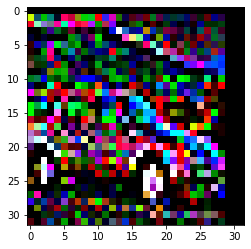

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


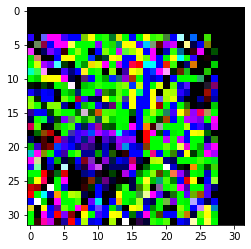

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


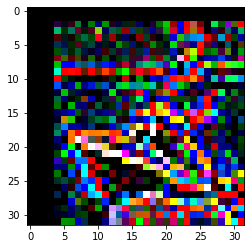

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


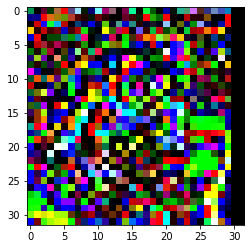

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


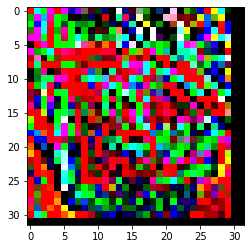

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


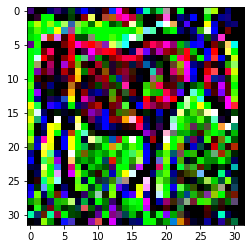

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


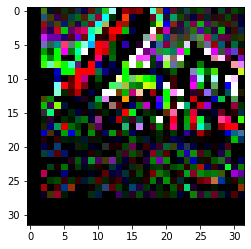

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


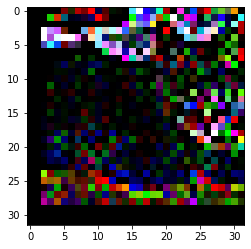

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


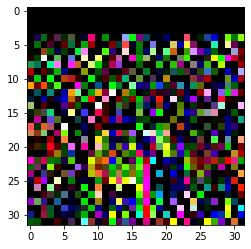

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


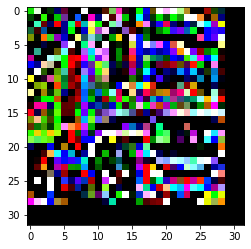

In [67]:
# Test 3: Hold both constant. The two outputs should be identical
test_randomness(0, 0)

Making train data...
GCN...
ZCA...
Done!
Slice of starting weights: [-0.15206625 -0.20624225 -0.19378448  0.02553999 -0.46414208  0.14036606
 -0.3824796  -0.42228398  0.40299827  0.28077036]
Epoch 1/5
10/10 [==============================] - 0s 3ms/step - loss: 2.3095 - accuracy: 0.1000
Epoch 2/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2916 - accuracy: 0.1000
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2727 - accuracy: 0.2000
Epoch 4/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2515 - accuracy: 0.3000
Epoch 5/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2274 - accuracy: 0.3000
Slice of ending weights: [-0.13424481 -0.24394126 -0.18426839  0.01758191 -0.42256165  0.1391424
 -0.40432316 -0.42205602  0.4015197   0.29912865]
Loss history: [2.3094913959503174, 2.2915642261505127, 2.272728204727173, 2.251450777053833, 2.227355480194092]
Dataset sample:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


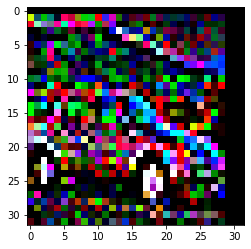

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


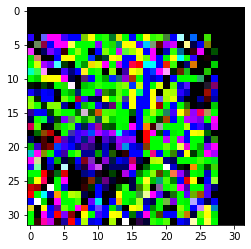

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


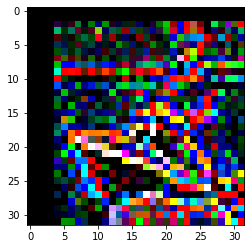

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


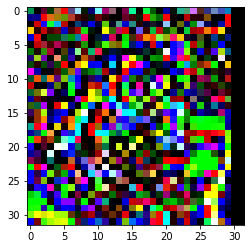

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


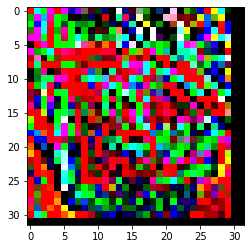

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


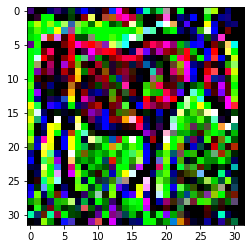

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


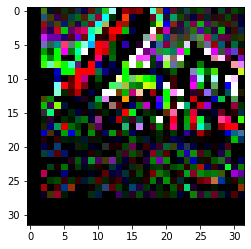

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


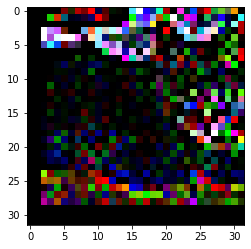

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


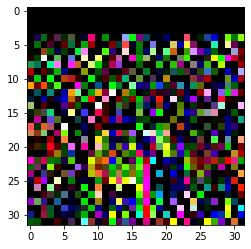

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


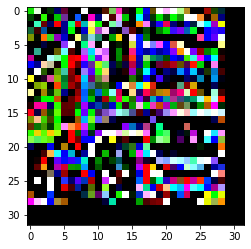

In [68]:
test_randomness(0, 0)

Making train data...
GCN...
ZCA...
Done!
Slice of starting weights: [-0.1495665  -0.19229503 -0.2810441   0.08478262  0.25390822 -0.5862417
  0.1485052  -0.272646   -0.5599455  -0.50446755]
Epoch 1/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2877 - accuracy: 0.2000
Epoch 2/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2705 - accuracy: 0.2000
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2430 - accuracy: 0.3000
Epoch 4/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2120 - accuracy: 0.3000
Epoch 5/5
10/10 [==============================] - 0s 3ms/step - loss: 2.1867 - accuracy: 0.4000
Slice of ending weights: [-0.12873521 -0.19432263 -0.35627237  0.08255961  0.2321619  -0.5339294
  0.16053294 -0.2629895  -0.5328559  -0.54915875]
Loss history: [2.287659168243408, 2.270512819290161, 2.2430293560028076, 2.21199893951416, 2.186701536178589]
Dataset sample:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


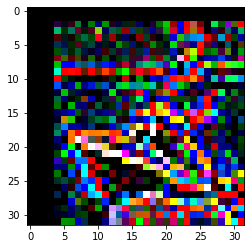

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


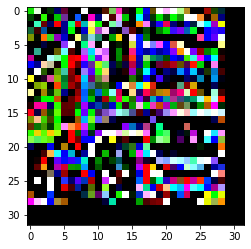

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


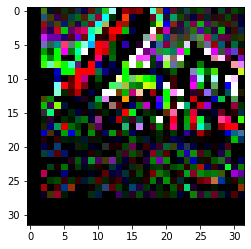

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


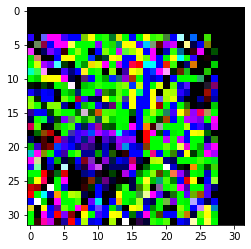

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


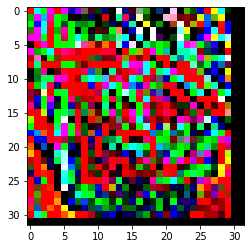

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


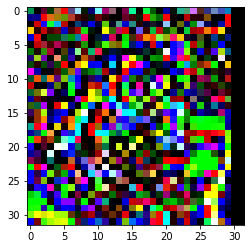

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


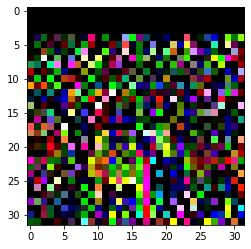

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


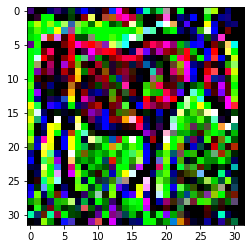

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


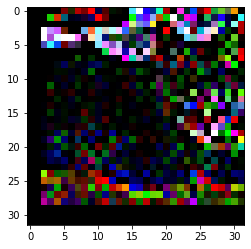

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


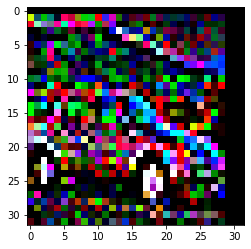

In [69]:
# Test 4: Weight is different but shuffle is constant. Images should come out the same.
test_randomness(39, 4)

Making train data...
GCN...
ZCA...
Done!
Slice of starting weights: [-0.04263135 -0.35741335 -0.07628422 -0.14070739  0.4474438   0.14138827
  0.32234615  0.36419111  0.02403274 -0.16564685]
Epoch 1/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2619 - accuracy: 0.2000
Epoch 2/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2482 - accuracy: 0.3000
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2247 - accuracy: 0.3000
Epoch 4/5
10/10 [==============================] - 0s 3ms/step - loss: 2.1990 - accuracy: 0.3000
Epoch 5/5
10/10 [==============================] - 0s 3ms/step - loss: 2.1779 - accuracy: 0.2000
Slice of ending weights: [-0.04098571 -0.39821157 -0.15813592 -0.13310614  0.4487359   0.13150704
  0.32025427  0.3492949   0.06102647 -0.19909376]
Loss history: [2.261899471282959, 2.248227119445801, 2.224733352661133, 2.198990821838379, 2.177905559539795]
Dataset sample:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


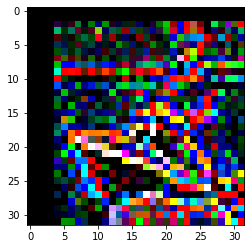

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


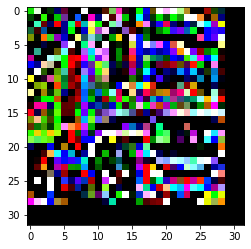

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


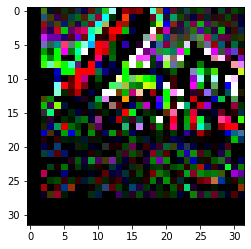

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


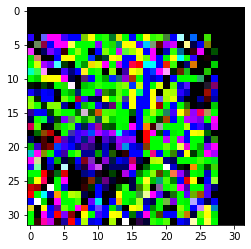

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


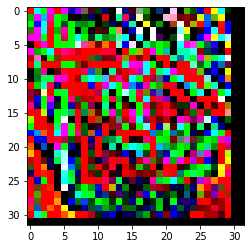

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


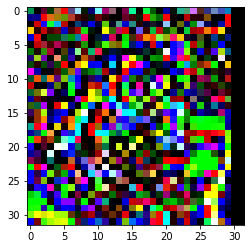

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


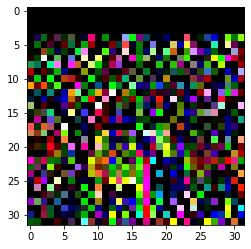

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


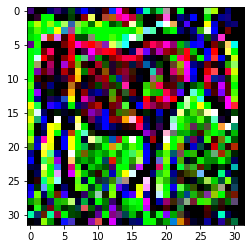

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


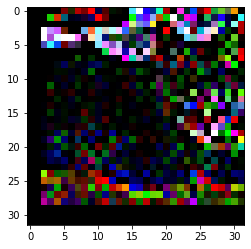

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


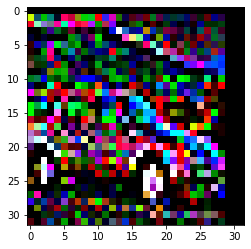

In [70]:
test_randomness(10001, 4)

Making train data...
GCN...
ZCA...
Done!
Slice of starting weights: [ 0.13506486 -0.00458091 -0.027039    0.03238151  0.45246583 -0.00605014
 -0.34779105  0.5989963   0.01595361 -0.42749077]
Epoch 1/5
10/10 [==============================] - 0s 4ms/step - loss: 2.3271 - accuracy: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 0s 4ms/step - loss: 2.3156 - accuracy: 0.1000
Epoch 3/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2990 - accuracy: 0.2000
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2772 - accuracy: 0.2000
Epoch 5/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2625 - accuracy: 0.2000
Slice of ending weights: [ 0.12305209  0.009428   -0.08382668  0.04166777  0.40361333 -0.00487013
 -0.37398693  0.5681341   0.01194102 -0.4152316 ]
Loss history: [2.3271408081054688, 2.3156063556671143, 2.299041748046875, 2.2771615982055664, 2.262526273727417]
Dataset sample:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


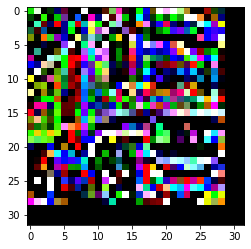

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


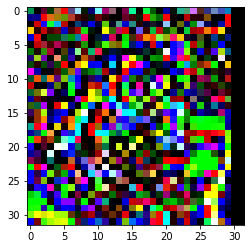

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


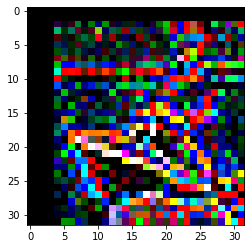

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


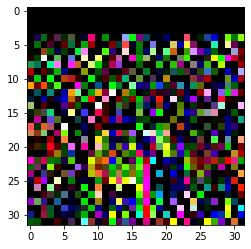

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


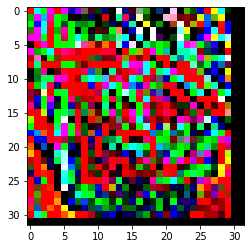

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


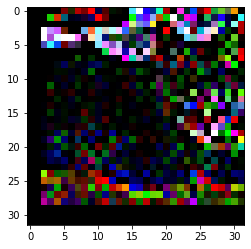

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


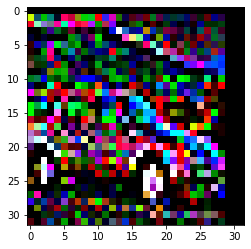

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


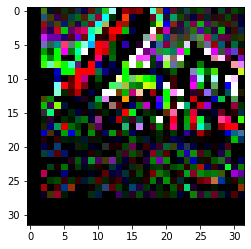

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


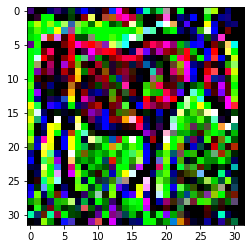

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


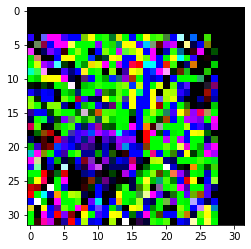

tf.Tensor(
[0.8759254  0.61969936 1.6061722  1.6837724  1.2500235  2.4234838
 1.4796753  2.9943876  2.0902054  0.3761208 ], shape=(10,), dtype=float32)


In [23]:
# Test 5: Weight and shuffle different. Images should be augmented the same way.
tf.random.set_seed(0)
test_randomness(123, 99)
print(tf.random.uniform(shape=[10], maxval=3, dtype=tf.float32))

Making train data...
GCN...
ZCA...
Done!
Slice of starting weights: [-0.27030313  0.3775387   0.34727952  0.12822542  0.38294438 -0.42198202
  0.22137085 -0.41904446 -0.08636434 -0.50748014]
Epoch 1/5
10/10 [==============================] - 0s 3ms/step - loss: 2.3090 - accuracy: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2965 - accuracy: 0.1000
Epoch 3/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2759 - accuracy: 0.2000
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 2.2547 - accuracy: 0.2000
Epoch 5/5
10/10 [==============================] - 0s 3ms/step - loss: 2.2361 - accuracy: 0.2000
Slice of ending weights: [-0.24796109  0.38346136  0.31614745  0.11406552  0.38303497 -0.38536793
  0.20153658 -0.4184619  -0.08711572 -0.50428414]
Loss history: [2.309011936187744, 2.2964909076690674, 2.275876522064209, 2.254732131958008, 2.23608136177063]
Dataset sample:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


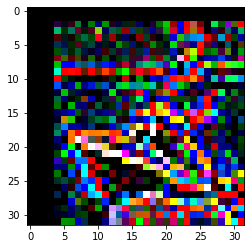

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


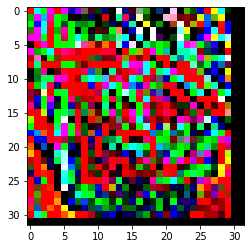

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


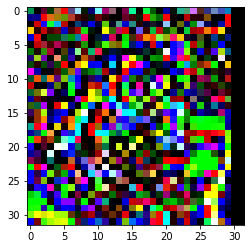

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


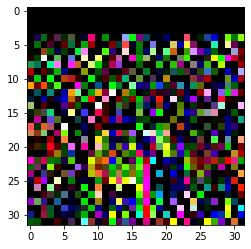

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


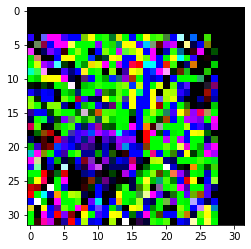

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


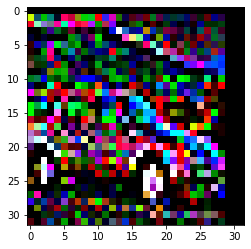

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


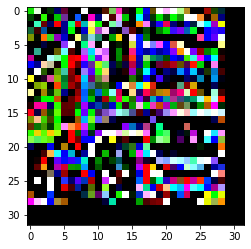

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


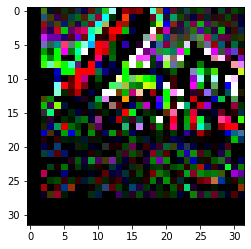

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


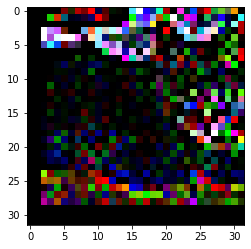

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


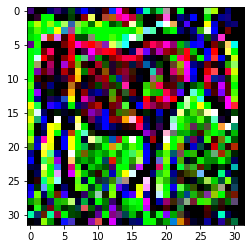

tf.Tensor(
[0.8759254  0.61969936 1.6061722  1.6837724  1.2500235  2.4234838
 1.4796753  2.9943876  2.0902054  0.3761208 ], shape=(10,), dtype=float32)


In [24]:
tf.random.set_seed(0)
tf.random.uniform(shape=[10], maxval=3, dtype=tf.float32, seed=912)
test_randomness(534, 706)
print(tf.random.uniform(shape=[10], maxval=3, dtype=tf.float32))


In [ ]:
# Ok so doing a tf random with 